# **Traffic Classification using Deep Learning**

### Import useful libraries

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 97 kB 5.0 MB/s 


In [ ]:
import pickle
import numpy as np
import pandas as pd
import sklearn
import imblearn
from imblearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import kerastuner as kt
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, Input
from tensorflow.keras.models import Model

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

### Link gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
path = "gdrive/MyDrive/Dataset_csv/"

Mounted at /content/gdrive


### Encode categorical features

In [ ]:
df = pd.read_parquet('gdrive/MyDrive/dataset_cnn_256.parquet')

In [ ]:
labels = np.array(df['class'])
labels = labels.astype("int32")
features = df.drop('class', axis=1)
features_list = list(features.columns)
features = np.array(features)
classes = np.unique(labels)

#one hot encoding classi finali

### Train-test splitting

In [ ]:
from sklearn.model_selection import train_test_split

samples_train, samples_test, categorical_labels_train, categorical_labels_test = \
    train_test_split(features,labels, shuffle=True, random_state=0, stratify=labels)

samples_train = np.expand_dims(samples_train, axis=2)
samples_test = np.expand_dims(samples_test, axis=2)

In [ ]:
from sklearn.metrics import plot_confusion_matrix 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from imblearn.metrics import geometric_mean_score


def evaluate(xtest, ytest, ypred, title):

  accuracy_score(ytest, ypred) #Accuracy

  macro_gmean = np.mean(geometric_mean_score(ytest, ypred, average=None))
  print('macro g-mean -> ' + str(macro_gmean))

  print(classification_report(ypred, ytest)) #Detailed metrics

  mat = confusion_matrix(ytest, ypred, normalize='true') #Confusion matrix seaborn
  plt.figure(figsize=(12, 8), dpi=70)
  ax = plt.subplot()
  sns.heatmap(mat.T*100, square=True, annot=True, vmin=0.0, vmax=100.0, 
              cbar=True, ax=ax, xticklabels=classes, yticklabels=classes, 
              linewidths=1,fmt='1.4f', annot_kws={"size":14}) 
  sns.set(font_scale=1.2) 
  plt.xlabel('True Label')
  plt.ylabel('Predicted Label')
  plt.title(title)

### Define DL CNN-based architecture

In [ ]:
def model_builder(hp):
  model = keras.Sequential()
  input_shape = samples_train.shape[1:]
  num_classes = len(set(categorical_labels_test))

  input_payload = Input(shape=input_shape, name='input_payload')
  model.add(Conv1D(filters=16, kernel_size=25, strides=1, kernel_constraint=MaxNorm(3), padding='same', activation='relu', name='Conv1'))
  
  model.add(MaxPooling1D(pool_size=3, strides=None, padding='same'))

  model.add(Conv1D(filters=32, kernel_size=25, strides=1, kernel_constraint=MaxNorm(3), padding='same', activation='relu', name='Conv2'))
  model.add(MaxPooling1D(pool_size=3, strides=None, padding='same'))

  model.add(Flatten())
  model.add(Dropout(0.2))

  model.add(Dense(256, activation='relu', kernel_constraint=MaxNorm(3)))
  model.add(Dropout(0.2))

  model.add(Dense(13, kernel_constraint=MaxNorm(3), activation='softmax', name='output_wang'))

  #model = Model(inputs=input_payload, outputs=output_payload, name='traffic_classification_1DCNN')

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-4]) #addestramento senza tuning, batch size

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

### Hyper-parameter tuning

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(samples_train, categorical_labels_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 1 Complete [00h 03m 57s]
val_accuracy: 0.6364818811416626

Best val_accuracy So Far: 0.6364818811416626
Total elapsed time: 00h 03m 57s
INFO:tensorflow:Oracle triggered exit


In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(samples_train, categorical_labels_train, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch))

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


16243/16243 [==============================] - 97s 6ms/step - loss: 1.0615 - accuracy: 0.6345 - val_loss: 1.0267 - val_accuracy: 0.6362
Epoch 2/50
16243/16243 [==============================] - 95s 6ms/step - loss: 1.0221 - accuracy: 0.6391 - val_loss: 1.0240 - val_accuracy: 0.6366
Epoch 3/50
16243/16243 [==============================] - 94s 6ms/step - loss: 1.0194 - accuracy: 0.6396 - val_loss: 1.0233 - val_accuracy: 0.6367
Epoch 4/50
16243/16243 [==============================] - 95s 6ms/step - loss: 1.0184 - accuracy: 0.6396 - val_loss: 1.0225 - val_accuracy: 0.6367
Epoch 5/50
16243/16243 [==============================] - 96s 6ms/step - loss: 1.0177 - accuracy: 0.6397 - val_loss: 1.0225 - val_accuracy: 0.6368
Epoch 6/50
16243/16243 [==============================] - 95s 6ms/step - loss: 1.0174 - accuracy: 0.6398 - val_loss: 1.0232 - val_accuracy: 0.6368
Epoch 7/50
16243/16243 [==============================] - 96s 6ms/step - loss: 1.0171 - accuracy: 0.6398 - val_loss: 1.0240 - val

### Model build

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(samples_train, categorical_labels_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


16243/16243 [==============================] - 96s 6ms/step - loss: 1.0605 - accuracy: 0.6340 - val_loss: 1.0284 - val_accuracy: 0.6355
Epoch 2/20
16243/16243 [==============================] - 95s 6ms/step - loss: 1.0228 - accuracy: 0.6391 - val_loss: 1.0250 - val_accuracy: 0.6364
Epoch 3/20
16243/16243 [==============================] - 95s 6ms/step - loss: 1.0200 - accuracy: 0.6393 - val_loss: 1.0234 - val_accuracy: 0.6367
Epoch 4/20
16243/16243 [==============================] - 95s 6ms/step - loss: 1.0185 - accuracy: 0.6396 - val_loss: 1.0234 - val_accuracy: 0.6367
Epoch 5/20
16243/16243 [==============================] - 96s 6ms/step - loss: 1.0178 - accuracy: 0.6398 - val_loss: 1.0226 - val_accuracy: 0.6367
Epoch 6/20
16243/16243 [==============================] - 95s 6ms/step - loss: 1.0175 - accuracy: 0.6397 - val_loss: 1.0249 - val_accuracy: 0.6368
Epoch 7/20
16243/16243 [==============================] - 95s 6ms/step - loss: 1.0170 - accuracy: 0.6399 - val_loss: 1.0226 - val

### Prediction

In [ ]:
eval_result = hypermodel.evaluate(samples_test, categorical_labels_test)
print("[test loss, test accuracy]:", eval_result)

soft_values = hypermodel.predict(samples_test, verbose=2)
prediction_test = soft_values.argmax(axis=-1)

6768/6768 [==============================] - 21s 3ms/step - loss: 1.0140 - accuracy: 0.6397
[test loss, test accuracy]: [1.0139875411987305, 0.6397057771682739]
6768/6768 - 9s


### Evaluate CNN-based traffic classifier

In [ ]:
soft_values = hypermodel.predict(samples_test, verbose=2)
prediction_test = soft_values.argmax(axis=-1)

accuracy = sklearn.metrics.accuracy_score(categorical_labels_test, prediction_test)
fmeasure = sklearn.metrics.f1_score(categorical_labels_test, prediction_test, average='macro')
macro_gmean = np.mean(imblearn.metrics.geometric_mean_score(categorical_labels_test, prediction_test, average=None))
classification_report = sklearn.metrics.classification_report(categorical_labels_test, prediction_test)

print('Accuracy: {}'.format(accuracy))
print('Macro F-measure: {}'.format(fmeasure))
print('Macro G-mean: {}'.format(macro_gmean))
print(classification_report)

6768/6768 - 9s
Accuracy: 0.6397057804989542
Macro F-measure: 0.25247220365815903
Macro G-mean: 0.2951753349252441
              precision    recall  f1-score   support

           0       1.00      0.01      0.03     19174
           1       0.99      0.18      0.30      5498
           2       0.79      0.85      0.81        13
           3       0.37      0.33      0.34      8418
           4       0.00      0.00      0.00       209
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         7
           7       0.98      0.03      0.06      9974
           8       0.20      0.25      0.22         4
           9       0.00      0.00      0.00     38119
          10       0.65      1.00      0.78    133596
          11       0.00      0.00      0.00       222
          12       0.86      0.63      0.73      1336

    accuracy                           0.64    216573
   macro avg       0.45      0.25      0.25    216573
weighted avg       0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Compute and show the confusion matrix

Text(0.5, 1.0, 'Confusion Matrix of DL Traffic Classifier in Log-scale')

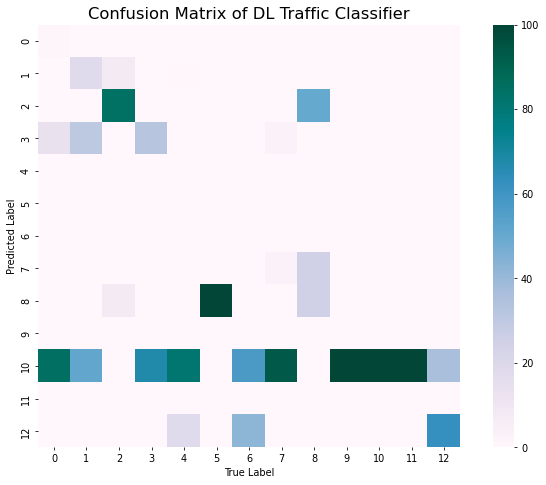

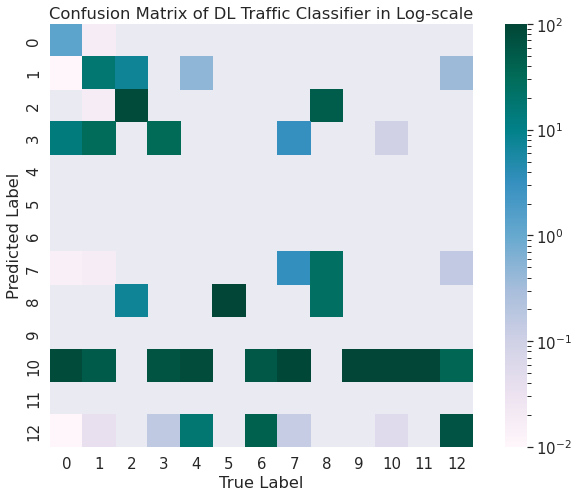

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

mat = confusion_matrix(categorical_labels_test, prediction_test, normalize = 'true')

plt.figure(figsize=(12, 8), dpi=70)
cmap = cm.get_cmap('PuBuGn')
ax = plt.subplot()
sns.heatmap(mat.T*100, square=True, annot=False, vmin=0.0, vmax=100.0, cmap=cmap, cbar=True,ax=ax,xticklabels=classes, yticklabels=classes) # plot via seaborn
sns.set(font_scale=1.4) # for label size
plt.xlabel('True Label')
plt.ylabel('Predicted Label');
plt.title('Confusion Matrix of DL Traffic Classifier')

plt.figure(figsize=(12, 8), dpi=70)
ax = plt.subplot()
sns.heatmap(mat.T*100, square=True, annot=False, vmin=0.0, vmax=100.0, cmap=cmap, cbar=True, norm=LogNorm(vmin=0.01, vmax=100.0),ax=ax,xticklabels=classes, yticklabels=classes) # plot via seaborn in logscale
sns.set(font_scale=1.4) # for label size
plt.xlabel('True Label')
plt.ylabel('Predicted Label');
plt.title('Confusion Matrix of DL Traffic Classifier in Log-scale')